In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import sqlite3
import openpyxl
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [26]:
class DomIdLoader:
    def __init__(self):
        self.url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}'


    def get_data(self, offset_: int = 0, limit_: int = 1000) -> list:
        params = {
                  'sortField': 'devId.devShortCleanNm',
                  'sortType': 'asc',
                  'objStatus': 0
                  }
        objids = []
        for offset_ in tqdm(range(offset_, 12000, limit_)):
            res = requests.get(url=self.url.format(offset_=offset_, limit_=limit_), params=params)
            while res.status_code == 999:
                res = requests.get(url=self.url.format(offset_=offset_, limit_=limit_), params=params)
            objects_data = res.json()
            objects_tmp_list = objects_data.get('data').get('list')
            objids_tmp = [x.get('objId') for x in objects_tmp_list]
            objids.extend(objids_tmp)
        return objids


class ObjectInfoExtractor:
    def __init__(self):
        self.url_obj = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{objId}'

    def load_data(self, list_ids: list) -> list:
        df = []
        for obj_id in tqdm(set(list_ids)):
            res = requests.get(url=self.url_obj.format(objId=obj_id))
            while res.status_code == 999:
                res = requests.get(url=self.url_obj.format(objId=obj_id))
            df.append(res.json())
        return df

    @staticmethod
    def df_converter(values: list):
        return pd.json_normalize(values)


class Saver:
    def __init__(self, data: pd.DataFrame) -> None:
        self.data = data

    def save_csv(self, path: str = 'file_df.csv') -> None:
        self.data.to_csv(path_or_buf=path)

    def save_xl(self) -> None:
        self.data.to_excel('file_df.xlsx')

    def save_pcl(self) -> None:
        self.data.to_pickle('file_df.pkl')

    def save_sql(self, title_db: str = 'test.db') -> None:
        self.data['objReady100PercDt'] = self.data['objReady100PercDt'].astype('str')
        self.data['rpdIssueDttm'] = self.data['rpdIssueDttm'].astype('str')
        self.data['loadDttm'] = self.data['loadDttm'].astype('str')
        self.data['objTransferPlanDt'] = self.data['objTransferPlanDt'].astype('str')
        self.data.to_sql('dom_rf_table', con=sqlite3.connect(title_db), if_exists='append', index=False)


class Visualizer:

    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.fig, self.ax = plt.subplots()
        self.fig.set_size_inches(10, 10)

    def make_barh(self, top, x_date, y_date, x_label, y_label, title):
        self.ax.barh(y=self.data[x_date][:top], width=self.data[y_date][:top])
        self.ax.invert_yaxis()  # labels read top-to-bottom
        self.ax.set_xlabel(x_label)
        self.ax.set_ylabel(y_label)
        self.ax.set_title(title)

        # добавляем линию, отсекая всех, кто набрал больше среднего
        avg = self.data[y_date].mean()
        competitors = self.data[self.data[y_date] > avg]
        self.ax.axhline(y=len(competitors)-0.5, color='r', label='Average', linestyle='--', linewidth=2)

        plt.show()

    def make_line(self, top, current_year: None, x_date, y_date, y_label, title, average: False):
        self.ax.tick_params(axis='x', labelrotation=45)
        self.ax.set_ylabel(y_label)
        self.ax.set_title(title)
        self.ax.grid(True)

        if current_year != None:
            self.current_year = current_year
            self.ax.plot(
                self.data[self.data.year == current_year][x_date][:top],
                self.data[self.data.year == current_year][y_date][:top],
                'o-b'
            )
        else:
            self.ax.plot(
                self.data[x_date][:top],
                self.data[y_date][:top],
                'o-b'
            )
        # добавляем линию, отсекая всех, кто набрал больше среднего
        if average:
            avg = self.data[self.data.year==current_year][y_date].mean()
            self.ax.axhline(y=avg, color='r', linestyle='--', linewidth=2)

        plt.show()

In [3]:
# Получить список ID объектов с сайта Дом.РФ
objids = DomIdLoader().get_data()


  0%|          | 0/12 [00:00<?, ?it/s]

In [7]:
# Получить все данные по объектам с сайта Дом.РФ из списка ID и создаем таблицу
df_res = ObjectInfoExtractor.df_converter(ObjectInfoExtractor().load_data(objids))

  0%|          | 0/10746 [00:00<?, ?it/s]

In [ ]:
df_res.head(3)

In [11]:
# Убираем в названии столбцов "data."
df_res = df_res.rename(columns=lambda x: x.replace('data.', ''))
# Считаем количество пропусков (nan) в таблице по столбцам
df_res.isnull().sum(axis=0)

Unnamed: 0                                    0
Unnamed: 0.1                                  0
errcode                                       0
id                                            1
hobjId                                        1
                                          ...  
developer.bankruptStage.bankruptLawUrl    10588
developer.orgBankruptMsgDttm              10588
rnvFlg                                    10657
rnvDTO                                    10657
data                                      10683
Length: 116, dtype: int64

In [25]:
# Сохраняем таблицу в формат csv
Saver(data=df_res).save_csv()

In [9]:
# Создание таблицы из csv файла
df_res = pd.read_csv('file_df.csv')

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (72,114,115) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
# Убираем колоник, где больше 30% пропусков
delete_columns = ['Unnamed: 0', 'metro.id', 'metro.name', 'metro.line', 'metro.color',
                  'metro.time', 'metro.isWalk', 'metro.colors', 'airQualityIndexValue',
                  'transportDistIndex', 'transportDistIndexValue', 'greenAreaIndexValue', 'complexShortNm',
                  'developer.bankruptStage.bankruptStageCd', 'developer.bankruptStage.bankruptStageDesc',
                  'developer.bankruptStage.bankruptLawUrl', 'developer.orgBankruptMsgDttm', 'rnvFlg', 'rnvDTO', 'data']
df_res.drop(delete_columns, axis=1, inplace=True)


In [13]:
df_res.head(2)

,Unnamed: 0.1,errcode,id,hobjId,pdId,developer.devId,developer.devShortCleanNm,developer.devShortNm,developer.devFullCleanNm,developer.problObjCnt,developer.buildObjCnt,developer.comissObjCnt,developer.regRegionDesc,developer.devPhoneNum,developer.devSite,developer.devEmail,developer.devInn,developer.devOgrn,developer.devKpp,developer.devLegalAddr,developer.devFactAddr,developer.lastRpdId,developer.fundGuarantyFlg,developer.devOrgRegRegionCd,developer.devEmplMainFullNm,developer.developerGroupName,developer.orgForm.id,developer.orgForm.fullForm,developer.orgForm.shortForm,developer.companyGroupId,developer.objGuarantyEscrowFlg,developer.govFundFlg,region,address,nameObj,floorMin,floorMax,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,objSquareLiving,rpdNum,rpdPdfLink,rpdIssueDttm,objLkLatitude,objLkLongitude,objCompensFundFlg,objProblemFlg,objLkClassDesc,loadDttm,photoRenderDTO,objGuarantyEscrowFlg,objectType,miniUrl,residentialBuildings,newBuildingId,objFloorCnt,objFlatCnt,objFlatSq,objNonlivElemCnt,quartography.objLivElem1KCnt,quartography.objLivElem2KCnt,quartography.objLivElem3KCnt,quartography.objLivElem4KCnt,quartography.objLivElemCnt,quartography.objLivElemEntrCnt,quartography.objLivElemEntrFloorAvg,objStatus,isAvailableWantLiveHere,objTransferPlanDt,objLivCeilingHeight,objInfrstrBicycleLaneFlg,objInfrstrPlaygrndCnt,objInfrstrSportGroundCnt,objInfrstrTrashAreaCnt,objInfrstrObjPrkngCnt,objInfrstrNotObjPrkngCnt,objInfrstrRampFlg,objInfrstrCurbLoweringFlg,objElevatorWheelchairCnt,objElevatorPassengerCnt,objElevatorCargoCnt,objElevatorCargoPassengerCnt,soldOutPerc,objPriceAvg,generalContractorNm,nonlivFirstFloor,objectTransportInfo,conclusion,objLkSaleDepEmail,objGreenHouseFlg,objEnergyEffShortDesc,infrastructureIndexValue
0,0,0,32787.0,43579.0,181636.0,6946.0,ТКС,ТКС,ТАТКАМСТРОЙ,0.0,2.0,4.0,Татарстан Республика,+7 (855) 544-03-74,www.таткамстрой.рф,tatkamstroy@mail.ru,1.650173e+09,1.081650e+12,165001001.0,"Татарстан Республика, г Набережные Челны, пр-к...","Респ Татарстан, г Набережные Челны, Автозаводс...",661716.0,0.0,16.0,Мусин Тагир Максимович,ТАТКАМСТРОЙ,4.0,Общество с ограниченной ответственностью,ООО,5460.0,1.0,0.0,16.0,"г Набережные Челны, вдоль проспекта Яшьлек, бл...","ЖК ""Современный""",12.0,13.0,99.0,2022-12-31,Монолит-кирпич,Без отделки,Нет,0.0,4226.31,16-000908,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,01-12-2022 13:37,55.7546,52.4556,0.0,0.0,Комфорт,23-12-2022 01:21,"[{'objId': 32787, 'pdId': 181636, 'rpdId': 661...",1.0,normal,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,1.0,43579.0,13.0,99.0,4226.31,3.0,55.0,33.0,11.0,0.0,99.0,1.0,9.0,0.0,True,28-02-2023 12:00,"2,8",0.0,1.0,1.0,1.0,89.0,282.0,1.0,1.0,0.0,1.0,1.0,1.0,1.000000,61816.0,"ООО ""Билант"" (ИНН: 1651000203)",1.0,[],True,tatkamstroy@mail.ru,1.0,A,8.0
1,1,0,32793.0,43585.0,162963.0,6434.0,СЗ ДЖЕВОССЕТ,СЗ ДЖЕВОССЕТ,СПЕЦИАЛИЗИРОВАННЫЙ ЗАСТРОЙЩИК ДЖЕВОССЕТ,0.0,1.0,0.0,Московская область,+7 (499) 688-60-86,www.microgorodvlesu.ru,info@microgorodvlesu.ru,5.012035e+09,1.065012e+12,502401001.0,"Московская область, г Красногорск, ул Школьная...",142402 обл Московская город Красногорск улица ...,648106.0,0.0,50.0,Заворотний Игорь Дмитриевич,ПроГород (группа ВЭБ.РФ),4.0,Общество с ограниченной ответственностью,ООО,9273.0,1.0,0.0,50.0,"г Красногорск, район Марьино, корпус 25","Микрогород ""В лесу""",9.0,13.0,545.0,2023-03-31,Монолит-кирпич,Под ключ,Нет,264.0,27631.00,50-003011,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,27-10-2022 19:20,55.8660,37.3293,0.0,0.0,Комфорт,23-12-2022 01:21,"[{'objId': 32793, 'pdId': 162963, 'rpdId': 648...",1.0,normal,https://xn--80az8a.xn--d1aqf.xn--p1ai/api/ext/...,1.0,43585.0,13.0,545.0,27631.00,111.0,225.0,227.0,48.0,45.0,545.0,8.0,7.0,0.0,True,31-08-2023 12:00,"2,8",1.0,1.0,2.0,1.0,139.0,0.0,1.0,1.0,0.0,14.0,8.0,22.0,0.863037,151912.0,"ООО ""Компания Б.В.С."" (ИНН: 7703543324)",1.0,"[{'metroStationNm': 'Митино', 'isMetroStationD...",False,info

## Рассчитать средние цены за квадратный метр по регионам

In [14]:
# Рассчет среднего значения стоимости по региону происходит без учета "nan"
df_Avg_Price = df_res.groupby(['developer.regRegionDesc']).agg({'objPriceAvg': 'mean'}).round(0)

In [15]:
df_Avg_Price = df_Avg_Price.sort_values(by='objPriceAvg', ascending=False).reset_index()
df_Avg_Price.head(10)

,developer.regRegionDesc,objPriceAvg
0,Москва город,271527.0
1,Санкт-Петербург город,174686.0
2,Севастополь город,154593.0
3,Сахалинская область,137448.0
4,Ленинградская область,136762.0
5,Московская область,132318.0
6,Забайкальский край,128604.0
7,Приморский край,122792.0
8,Татарстан Республика,122480.0
9,Саха (Якутия) Республика,120883.0


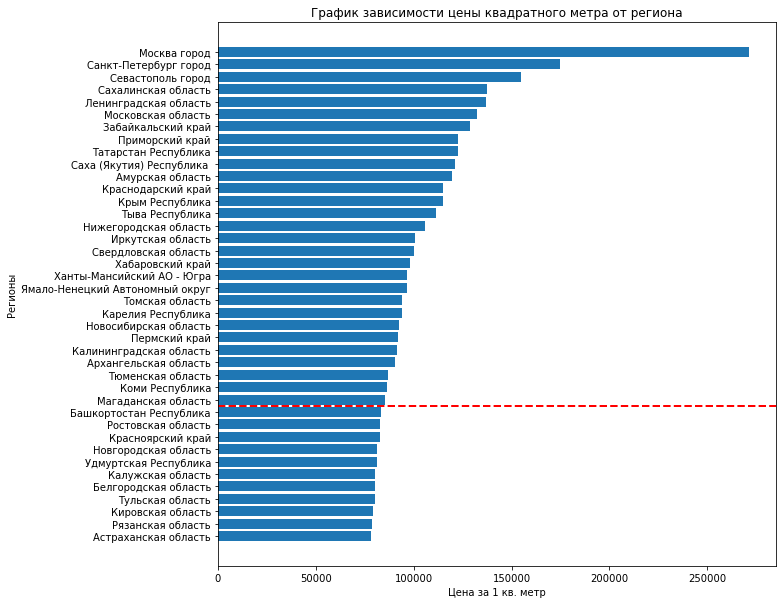

ВЫВОД: В 29 из 78 регионов стоимость за кв. метр больше среднего значения (на графике обозначено красной линией)


In [16]:
## Построение графика зависимости стоимости кв. метра от региона для топ 40 регионов
## Красный штрих - линия среднего значения стоимости кв. метра среди всех регионов
Visualizer(df_Avg_Price).make_barh(
    top=40,
    y_date='objPriceAvg',
    x_date='developer.regRegionDesc',
    x_label='Цена за 1 кв. метр',
    y_label='Регионы',
    title= 'График зависимости цены квадратного метра от региона'
)
print('ВЫВОД: В 29 из 78 регионов стоимость за кв. метр больше среднего значения '
      '(на графике обозначено красной линией)')



## Рассчитать объемы вводимого жилья по регионам и по годам

In [17]:
## Добавим в таблицу год сдачи объекта, и посчитаем сдаваемую площадь по регионам и годам
df_res["year"] = pd.to_datetime(df_res.objReady100PercDt, format='%Y-%m-%d').dt.strftime('%Y')
df_Housing_Volume = df_res.groupby(['year','developer.regRegionDesc']).agg({'objSquareLiving': 'sum'}).round(0)
df_Housing_Volume = df_Housing_Volume.sort_values(by=['year', 'objSquareLiving'], ascending=False).reset_index()
df_Housing_Volume.head(10)

,year,developer.regRegionDesc,objSquareLiving
0,2039,Свердловская область,0.0
1,2038,Свердловская область,8766.0
2,2036,Астраханская область,24301.0
3,2036,Рязанская область,23702.0
4,2036,Свердловская область,11203.0
5,2034,Свердловская область,5844.0
6,2033,Астраханская область,20977.0
7,2033,Курская область,3821.0
8,2033,Ленинградская область,0.0
9,2032,Самарская область,20746.0


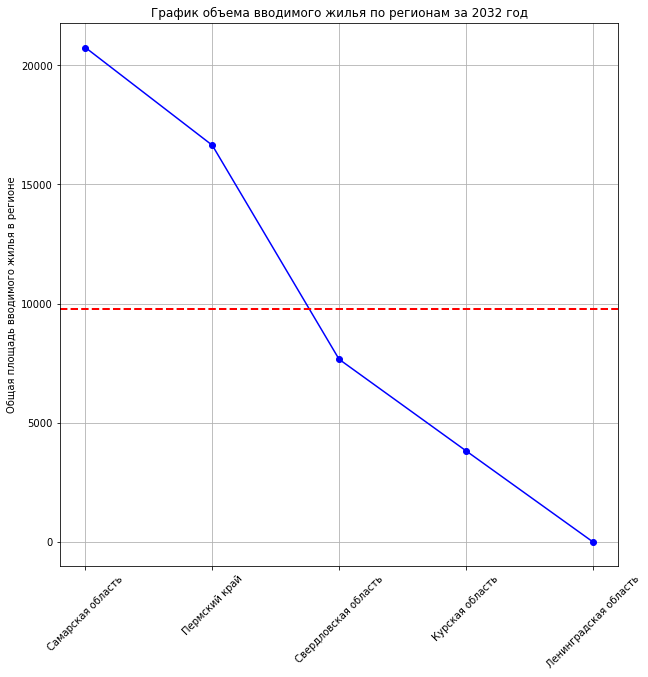

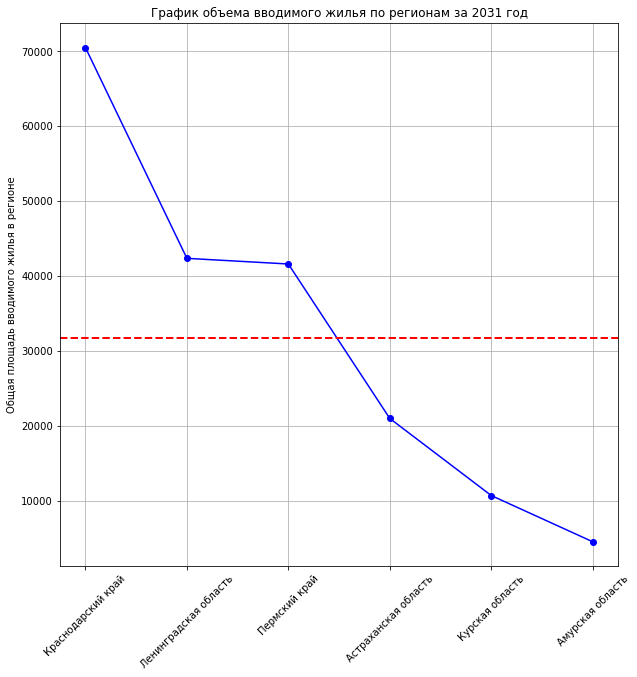

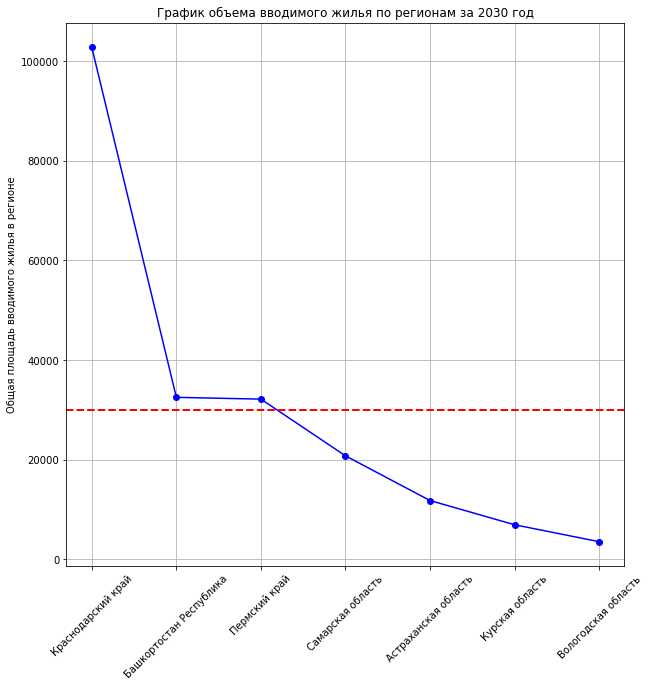

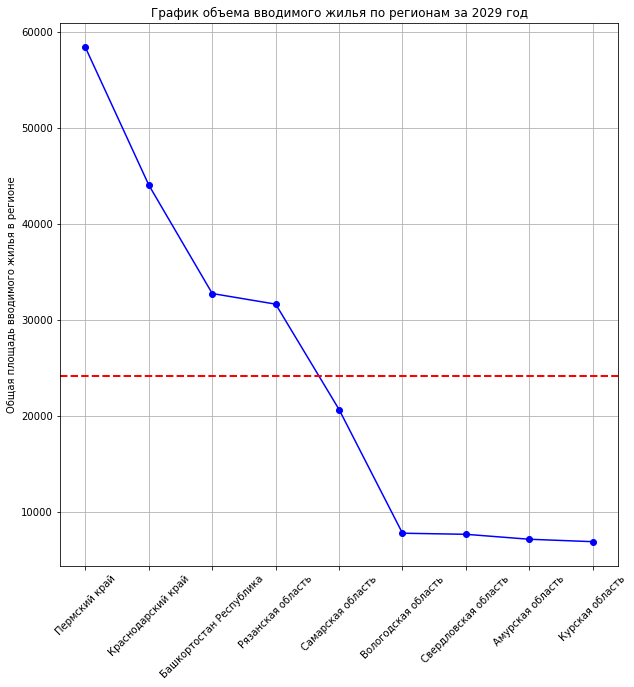

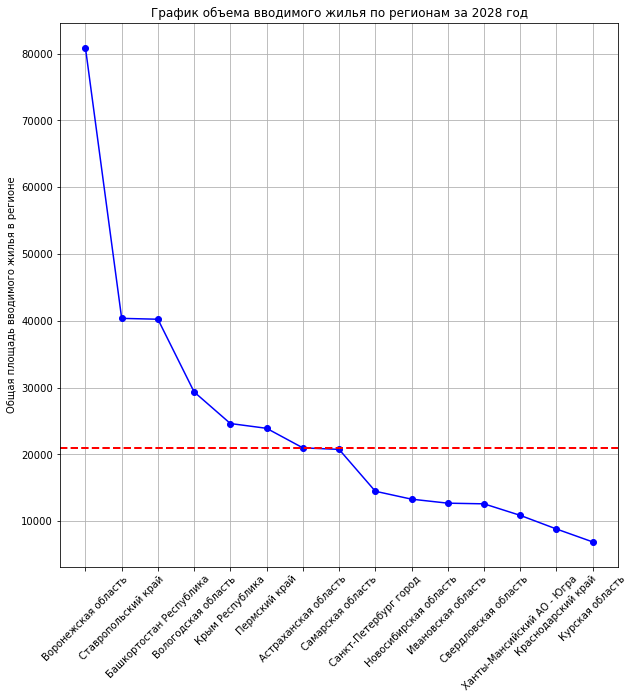

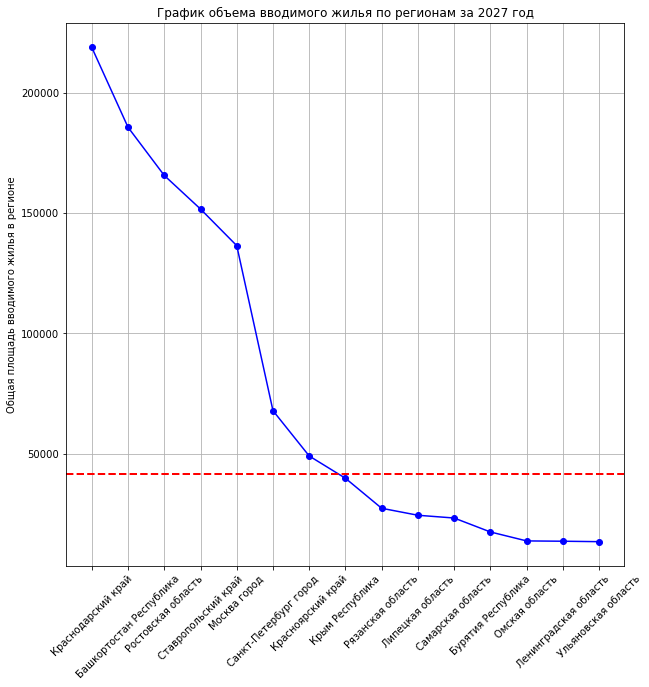

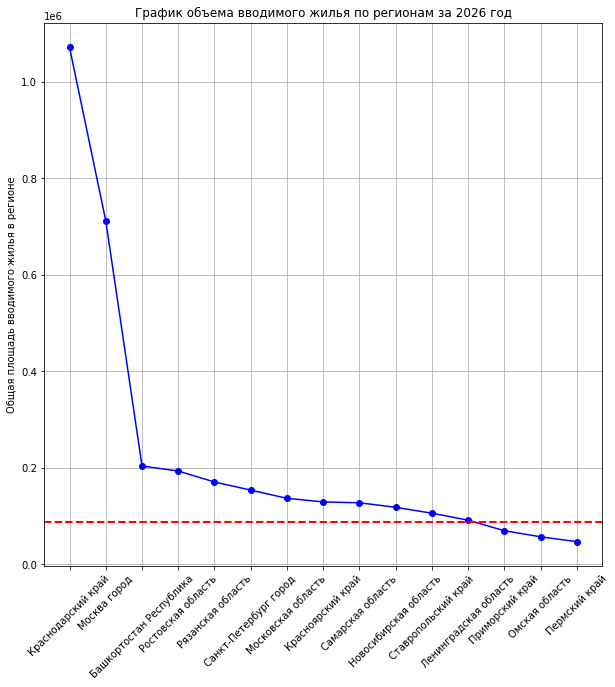

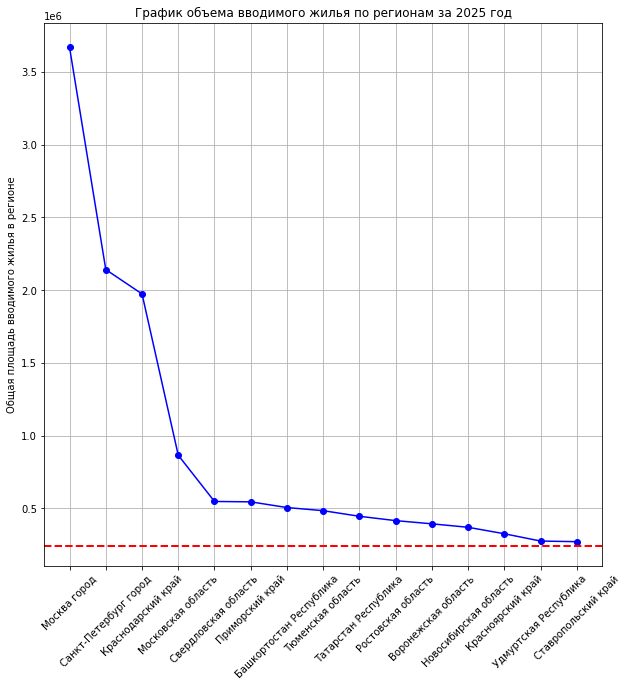

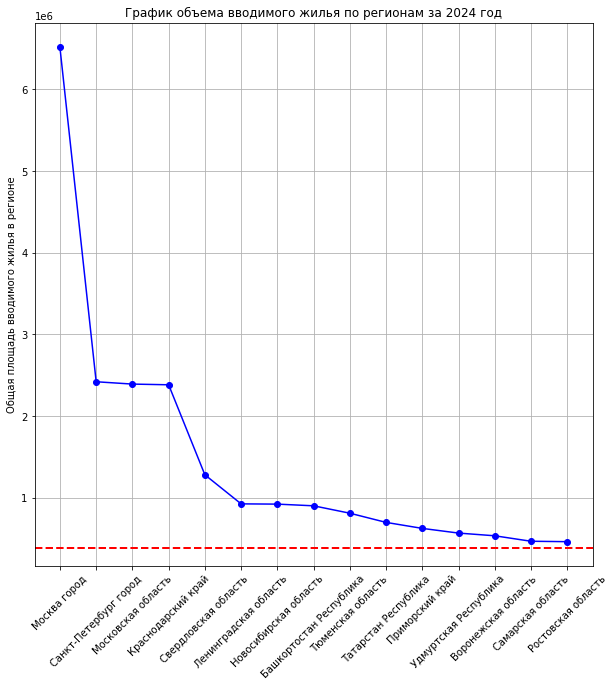

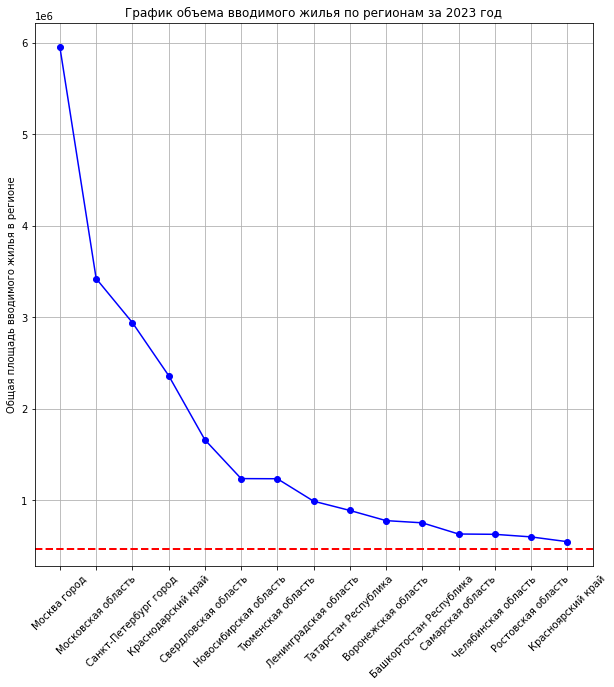

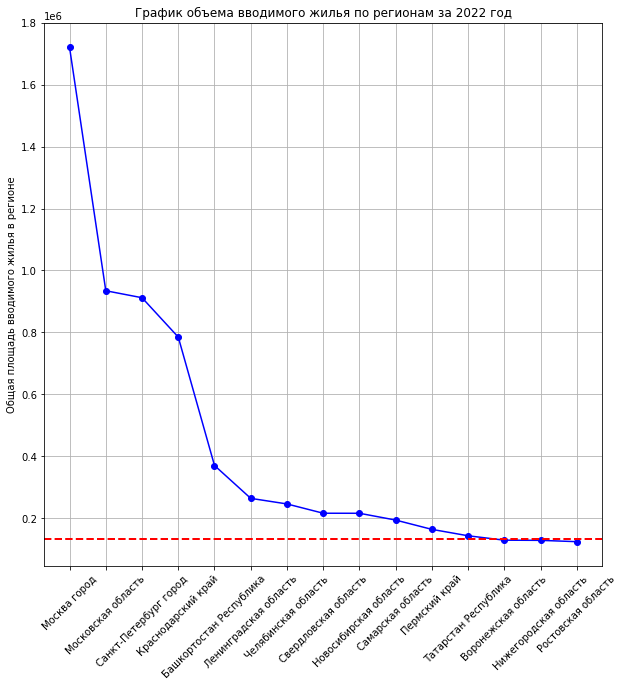

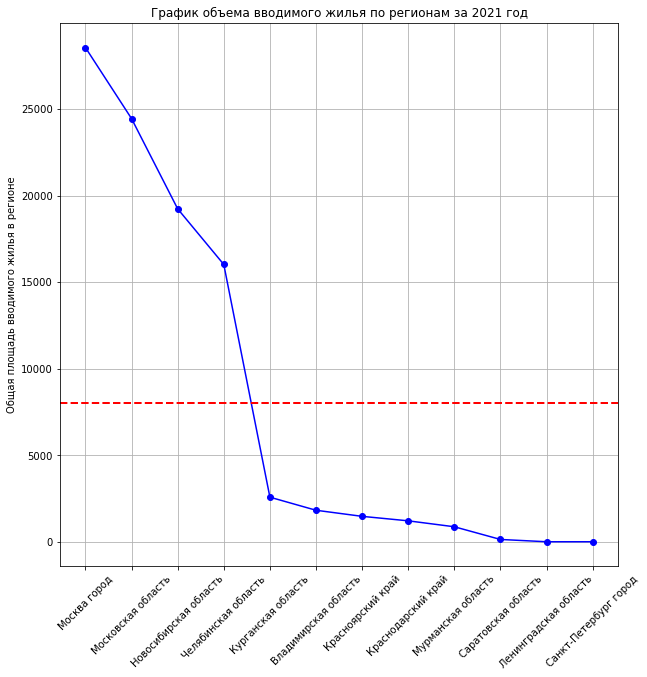

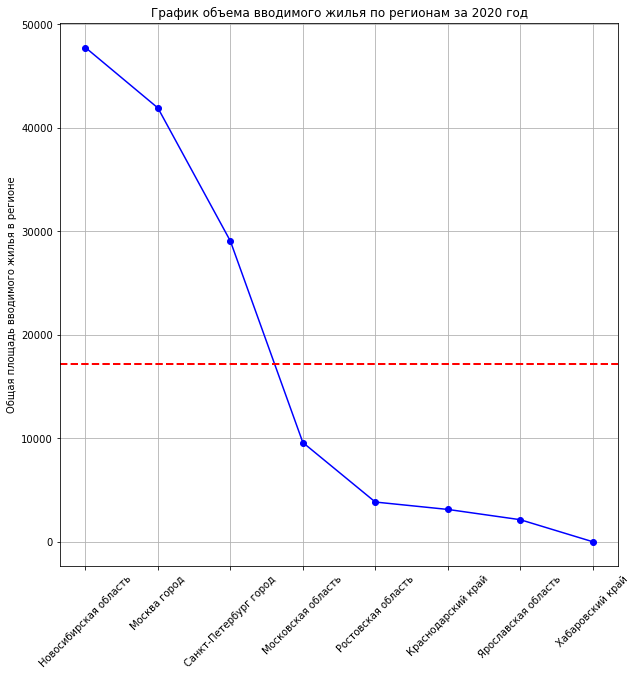

ВЫВОД: С 2022 года по 2025 год во всех регионах наблюдается, что обьем вводимого жилья во всех регионах меньше среднего


In [18]:
## Построение графиков по годам
for year in df_Housing_Volume.year.unique()[:-1]:
    if df_Housing_Volume[df_Housing_Volume.year==year]['developer.regRegionDesc'].count() > 3:
        Visualizer(df_Housing_Volume).make_line(
        current_year=year,
        top=15,
        x_date='developer.regRegionDesc',
        y_date='objSquareLiving',
        y_label='Общая площадь вводимого жилья в регионе',
        title= f'График объема вводимого жилья по регионам за {year} год',
        average= True
    )
print('ВЫВОД: С 2022 года по 2025 год во всех регионах наблюдается, '
      'что обьем вводимого жилья во всех регионах меньше среднего')

## Сравнить этажность домов, количество квартир, жилую площадь,
## количество парковочных мест и цену за квадратный метр в разных регионах

In [19]:
df_last = pd.DataFrame(df_res, columns=['developer.regRegionDesc', 'objFloorCnt', 'objFlatCnt', 'objFlatSq', 'objElemParkingCnt', 'objPriceAvg']).dropna()
df_last.head(10)

,developer.regRegionDesc,objFloorCnt,objFlatCnt,objFlatSq,objElemParkingCnt,objPriceAvg
0,Татарстан Республика,13.0,99.0,4226.31,0.0,61816.0
1,Московская область,13.0,545.0,27631.00,264.0,151912.0
2,Ивановская область,8.0,183.0,8770.60,0.0,51105.0
3,Московская область,3.0,22.0,1540.00,0.0,160261.0
4,Московская область,3.0,22.0,1540.00,0.0,148909.0
5,Московская область,3.0,22.0,1540.00,0.0,146548.0
7,Москва город,27.0,1314.0,78724.30,691.0,302158.0
8,Ярославская область,11.0,169.0,13896.74,79.0,94843.0
9,Дагестан Республика,12.0,499.0,36313.20,0.0,19447.0
10,Дагестан Республика,13.0,161.0,13001.82,0.0,24000.0


In [20]:
df_last_mean = df_last.groupby(['developer.regRegionDesc']).mean().sort_values(by=['objPriceAvg'], ascending=False).reset_index()
df_last_mean.head(10)

,developer.regRegionDesc,objFloorCnt,objFlatCnt,objFlatSq,objElemParkingCnt,objPriceAvg
0,Москва город,19.552661,357.746319,18845.549411,115.278596,271526.693092
1,Санкт-Петербург город,12.825160,338.213220,14312.056183,62.492537,174685.641791
2,Севастополь город,8.571429,96.571429,4509.905000,18.714286,154593.000000
3,Сахалинская область,9.131579,105.315789,5519.933947,13.289474,137447.947368
4,Ленинградская область,12.543210,333.728395,13400.413827,21.024691,136761.512346
5,Московская область,13.685771,291.675889,13421.152372,43.604743,132317.527668
6,Забайкальский край,12.100000,103.000000,4975.500000,0.000000,128604.200000
7,Приморский край,15.720497,177.086957,8743.361491,56.701863,122791.956522
8,Татарстан Республика,13.751323,197.656085,10056.966243,49.068783,122480.142857
9,Саха (Якутия) Республика,12.531250,156.812500,7945.792812,3.906250,120883.468750


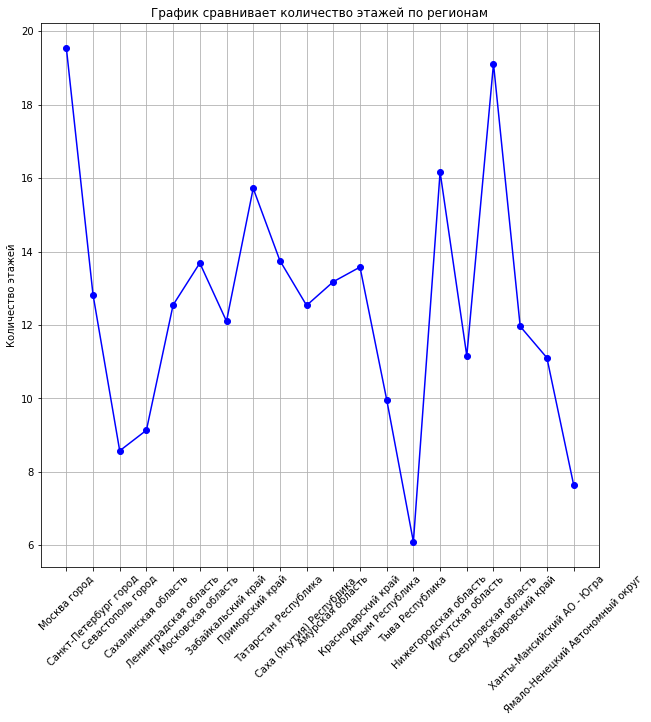

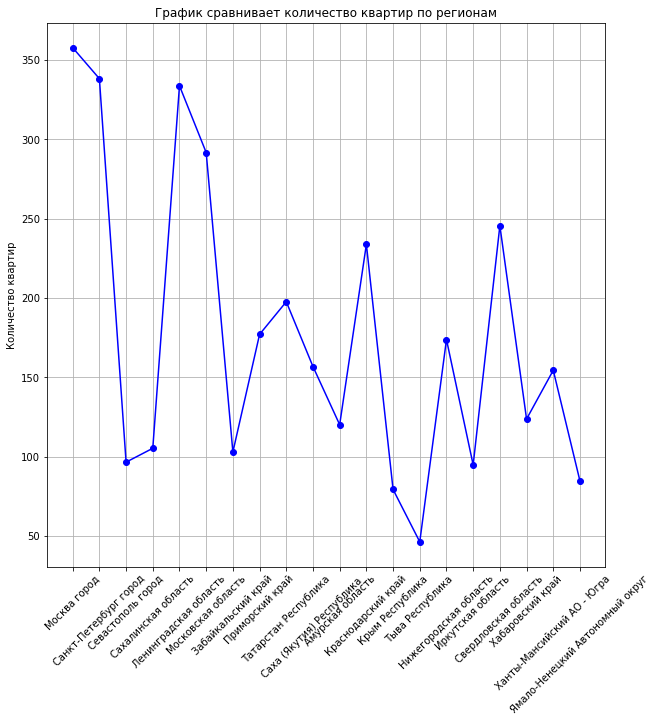

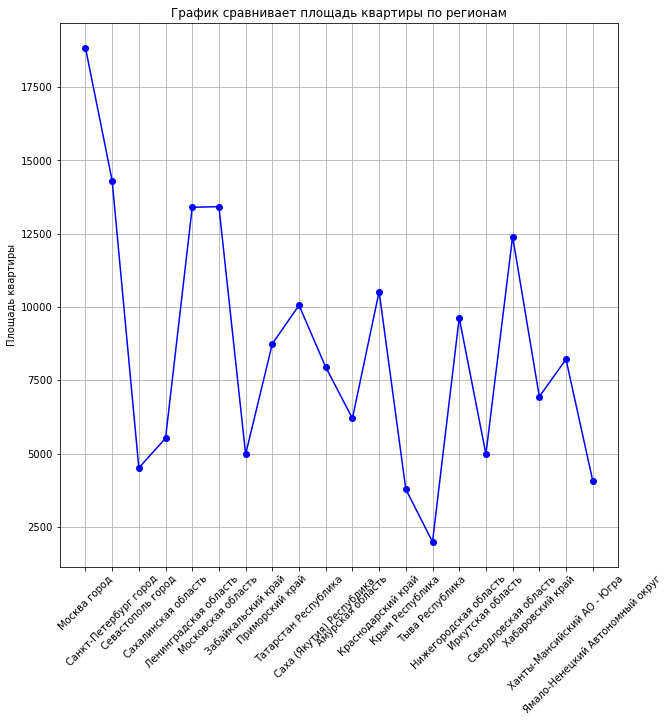

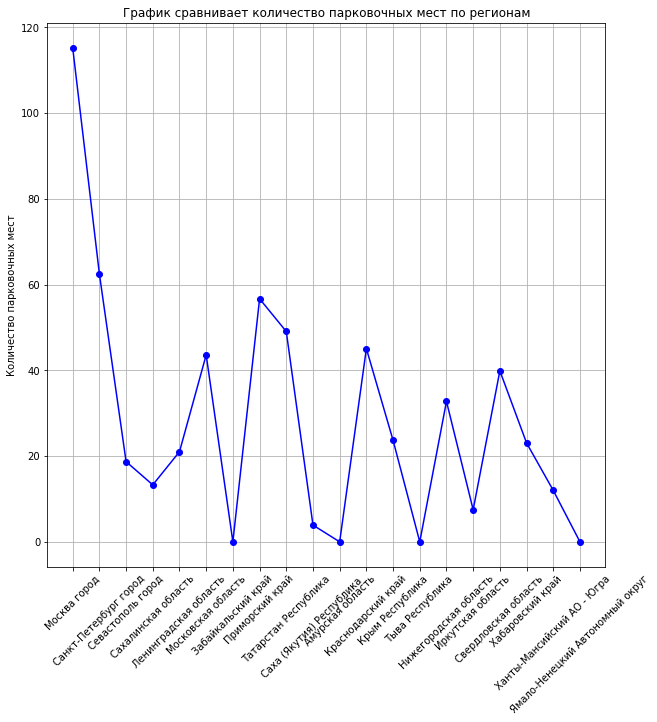

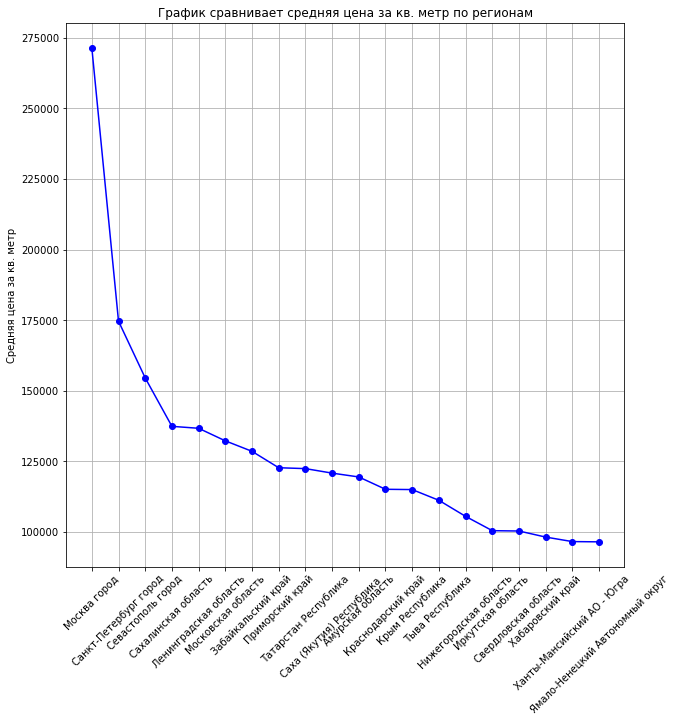

ВЫВОД: Из графиков для ТОП 20 регионов с самой высокой стоимостью за кв. метр видно,
что средние значения количества этажей, квартир, парковочных мест и площадей квартир
коррелируют между собой, но не коррелируют со средним значением стоимости за кв. метр


In [27]:
rename = {
    'objFloorCnt': 'Количество этажей',
    'objFlatCnt': 'Количество квартир',
    'objFlatSq': 'Площадь квартиры',
    'objElemParkingCnt': 'Количество парковочных мест',
    'objPriceAvg': 'Средняя цена за кв. метр'
}
## Построить графики по регионам в зависимости от других параметров
for key in rename.keys():
    Visualizer(df_last_mean).make_line(
    top=20,
    x_date='developer.regRegionDesc',
    y_date=key,
    y_label=rename[key],
    title= f'График сравнивает {rename[key].lower()} по регионам',
    average=False,
    current_year=None
)
print('ВЫВОД: Из графиков для ТОП 20 регионов с самой высокой стоимостью за кв. метр видно,\n'
      'что средние значения количества этажей, квартир, парковочных мест и площадей квартир\n'
      'коррелируют между собой, но не коррелируют со средним значением стоимости за кв. метр')